In [1]:
import gym as gym
env = gym.make("LunarLander")

D:\Anaconda3\envs\Reinforcement_Learning\lib\site-packages\gym\envs\registration.py:563: UserWarning: WARN: Using the latest versioned environment `LunarLander-v2` instead of the unversioned environment `LunarLander`.
  logger.warn(


In [2]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
Transition = namedtuple('Transition','state action next_state reward')

class Memory(object):

    def __init__(self) -> None:
        self.memory = deque(maxlen=10000)
        self.batch_size = 128
    
    def cache(self, *args):
        self.memory.append(Transition(*args))
    
    def recall(self):
        return random.sample(self.memory,self.batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
num_actions = env.action_space.n

state,info = env.reset()
num_observations = len(state)

In [7]:
class DQN(nn.Module):
    
    def __init__(self,num_observations,num_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128,128)
        self.layer4 = nn.Linear(128,num_actions)

    def forward(self,x):
        x = fun.leaky_relu(self.layer1(x))
        x = fun.leaky_relu(self.layer2(x))
        x = fun.leaky_relu(self.layer3(x))
        return self.layer3(x)

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.001
LR = 1e-4

policy_net = DQN(num_observations, num_actions)
target_net = DQN(num_observations, num_actions)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(),lr=LR,amsgrad=True)
memory = Memory()

In [9]:

steps = 0 

def act(state):
    global steps
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps / EPS_DECAY)
    steps += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long)

In [10]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Reward per Episode')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.recall()

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

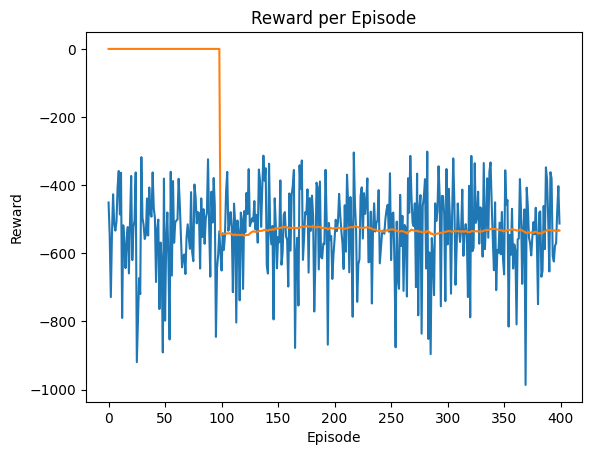

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
EPOCHS = 200

for i_episode in range(EPOCHS):
    reward_total = 0
    
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    for t in count():
        action = act(state)
        action = np.clip(action, -1, 1)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print("REWARD = ",reward)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Store the transition in memory
        memory.cache(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            plot_durations()
            break

plot_durations(show_result=True)
plt.ioff()
plt.show()

In [16]:
import numpy as np